In [6]:
import numpy as np
import tensorflow as tf
import os
import cv2
%matplotlib inline 
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [29]:
# Constants
DATASET_PATH = "dataset"
IMAGE_SIZE = (128,128)
BATCH_SIZE = 32
CLASS_NAMES = ["fire", "nonfire"]

In [36]:
# Load the data
image_gen = ImageDataGenerator(rescale=1./255)
images = image_gen.flow_from_directory(
    directory=DATASET_PATH,
    shuffle=True,
    target_size=IMAGE_SIZE,
    class_mode="binary",
    classes=CLASS_NAMES,
    batch_size=batch_size
)

Found 2621 images belonging to 2 classes.


/home/martin/.local/share/virtualenvs/d7041e-mini-project-qo9XQE3w/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  


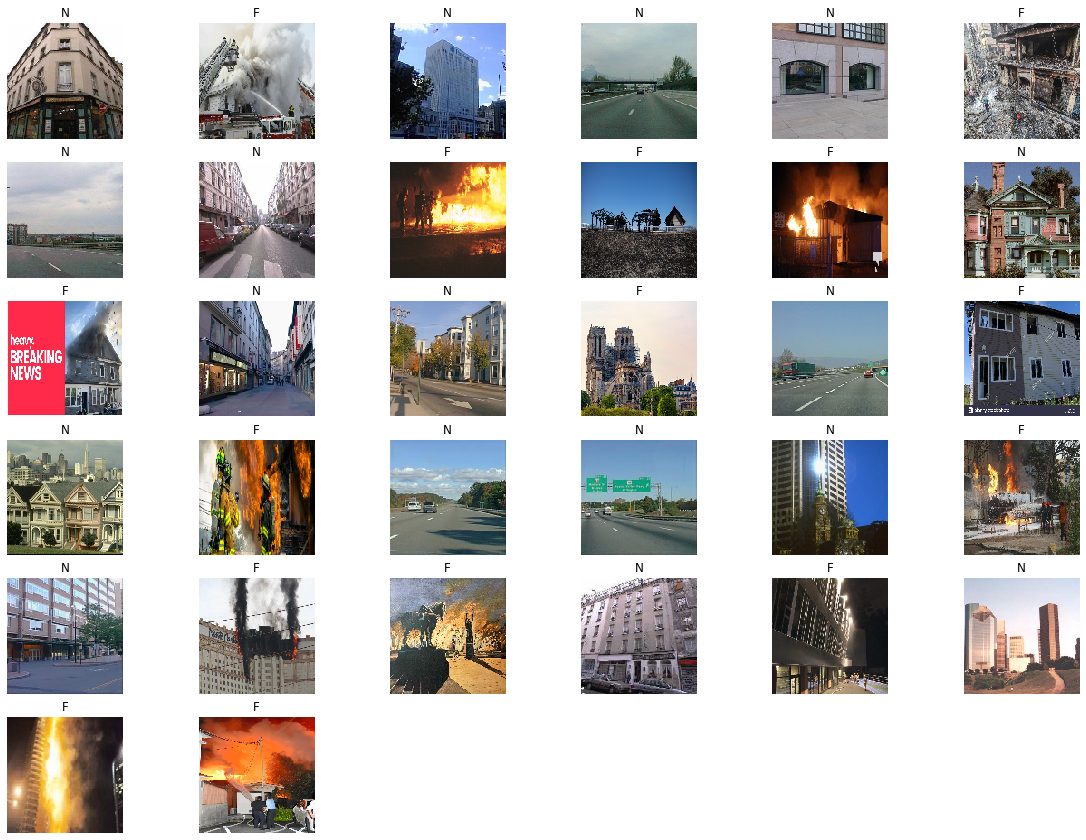

In [72]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(20,20))
  for n in range(batch_size):
      ax = plt.subplot(8, 6,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')
        
# Display the first batch        
image_batch, label_batch = next(images)
show_batch(image_batch, label_batch)

In [69]:
print(f'Loaded {BATCH_SIZE * (len(images) - 1) + len(images[len(images) - 1][0])} images')
print(f'Created {len(images)} batches')

Loaded 2621 images
Created 82 batches
